<a href="https://colab.research.google.com/github/brian-ho/intro-to-urban-data/blob/main/Measure/M07_Accessing_image_color_
data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **07 Measure** Accessing image color data
```
    Class       ARCH 6131 Urban Design Methods / Skills / Tools 1
                The Gensler Family AAP NYC Center
                Fall 2024
                Monday 3:30 PM to 6 PM

    Instructor  Brian Ho
                brian@brian-ho.io
```

This notebook explores how to access image data: both the visuals (actual pixels) and associated metadata (information about the photo). It assumes you've understood the first few notebooks. In particular, how we load in external libraries and packages, the basics of data structures and functions, and reading and writing files.

- Accessing color data
- Accessing pixels

To open HEIC photos taken by iPhone, we'll need an additional package called `pillow-heif`.

In [ ]:
!pip install pillow-heif --quiet

After installing the libraries, we'll need to import the right libraries into this notebook.

In [1]:
import PIL
from pathlib import Path
from pillow_heif import HeifImagePlugin

... and connect to Google Drive and set the appropriate directory for the example data. You can find it here on [GitHub](https://github.com/brian-ho/intro-to-urban-data/tree/main/Measure/Example%20Data). Or, try this with your own data!

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Don't forget to set the right path for your files!

In [2]:
# If you're connected to Google Drive, your path might be something like: /content/drive/example/folder
EXAMPLE_DATA_DIRECTORY = "example_data"

## Color modes
`PIL` lets you work with images in a few **color modes**. These define how the image represents color data for each pixel. If you've used software for printing (like InDesign), you may be familiar with CMYK representations — which `PIL` does support!

In this course you may encounter:

- `RGB` 3x8-bit pixels, true color
- `RGBA` 4x8-bit pixels, true color with alpha (transparency)
- `L` 8-bit pixels, usually greyscale
- `1` 1-bit pixels, black and white, stored with one pixel per byte
- `P` 8-bit pixels, using a palette (typically of 256 colors)

"8-bit pixels" mean the colors for a pixel are stored in the file as sets of eight bits, each of which can be either 1 or 0.

If you remember your powers of two, this means 8-bits can represent 2^8 = 256 unique values. And so 3x8-bit pixel means the color is stored as 3 consecutive 8-bit values. For that reason, when you work with say an image in `RGB` mode, you'll see that each red, green, or blue value is defined as an integer from 0 to 255. 8 bits are used quite a lot — and these are commonly referred to as "bytes"!

In [16]:
# Let's check the mode of the smaller image we created earlier — it should be RGB
smaller_img.mode

'RGB'

In `RGB` mode, the color red is represented as (255, 0, 0): full value for red, and no value for green and blue.  Remember, we use a 0-index. So starting from 0 and ending with 255 gives exactly 256 values.

`PIL` also makes it possible to convert this image to an alternative color mode. `L` mode is what you might think of as "greyscale", represented by 256 possible color from white to black.

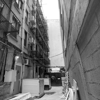

In [17]:
# Convert the image to a different color mode
# "L" is for "Luminance", but it means there's one color channel
# Which is equivalent to greyscale
smaller_img.convert("L")

And finally, the `1` mode means each pixel in the image is represented with a _single bit_. This means every pixel can be displayed entirely as either black or white. This produces a "dithering" effect as `PIL` applies some algorithms to convert colors to black and white.

This is a form of image data compression! Each pixel in `RGB` is represented by _three bytes_ with each byte being eight bits. In `L` mode, each pixel is represented by only _one bit_. So the files get much smaller, but you lose some meaning in the image. We'll play with this tension between summarizing data concisely and seeing its full detail and color throughout the class.

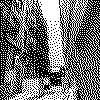

In [18]:
# Black and white — notice the dithering effect
smaller_img.convert("1")

Can you estimate roughly how much smaller — in terms of file size — an image is, when you convert from `RGB` to `L` mode?

## Histograms
`PIL` can let you analyze color frequency in an image which is another way to explore the data. Let's start with a histogram — a kind of data visualization that shows the frequency of values in a dataset.

In this case, we want to show how many pixels have each of the 256 values of red, green, and blue. This would let us understand: are those three components colors relatively matched? Is there a bias toward one in particular?

`PIL` has a nifty `Image.histogram()` method. This returns a list which is 256 x 3 = 768 values long. The list has (in order) the number of pixels for each value from 0 to 255 in first the red, then green, then blue colors. So something like:

```
[
    9934, # 9934 pixels have an R value of 0 
    5430, # 5430 pixels have an R value of 1
    ...
]
```

In [19]:
# Call the histogram method to get a list of frequency values
hist = img.histogram()

print(f"There are {len(hist)} items in the list, or 256 x 3.")
print(
    f"The first item looks like {hist[0]} — there are {hist[0]} pixels with a red value of 0"
)

print(f"The first five items look like {hist[:10]}")

There are 768 items in the list, or 256 x 3.
The first item looks like 88031 — there are 88031 pixels with a red value of 0
The first five items look like [88031, 31704, 27448, 25389, 23617, 22856, 22783, 22854, 23327, 23754]


OK, so we have our data. In order to plot it, we'll use `pandas` which provides some simply utility methods to do so.

First, we need to make a DataFrame, or 2D table from the data. Here we use a range to get a slice from a list — `hist[:256]` gets all the values from the 1st (0) to the 256th (255).

In [20]:
# We'll need pandas to make a DataFrame, or 2D table
import pandas as pd

# This creates a table with 3 columns, where each column is one of the R, G, or B colors
# The rows represent the number of pixels that have that R, G, or B value
# e.g. the 2nd row indicates how many pixels have R, G, and B values of 2.
df = pd.DataFrame({"red": hist[:256], "green": hist[256:512], "blue": hist[512:]})
df

,red,green,blue
0,88031,27523,23253
1,31704,27738,8172
2,27448,26847,17802
3,25389,24444,16478
4,23617,21173,21003
...,...,...,...
251,4023,2650,11841
252,6465,2424,10495
253,3304,2733,20749
254,117428,5024,8440


Finally, we can plot the data table. This version of a histogram is a line graph, which shows one line for each color, and connects all the values between 0 and 255.

Look at the result — what does it mean? There's a large spike in values where R, G, or B equal 255. Why might that be? Hint: (255, 255, 255) is the RGB color for white.

<Axes: >

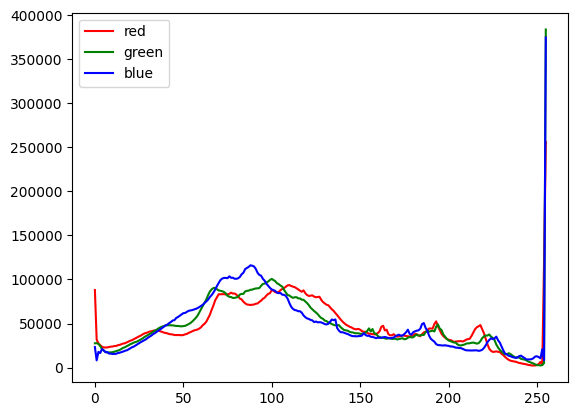

In [21]:
# Plot the histogram as a line frequency chart
df.plot(color=df.columns)

Of course, you can also plot this as an area chart!

<Axes: >

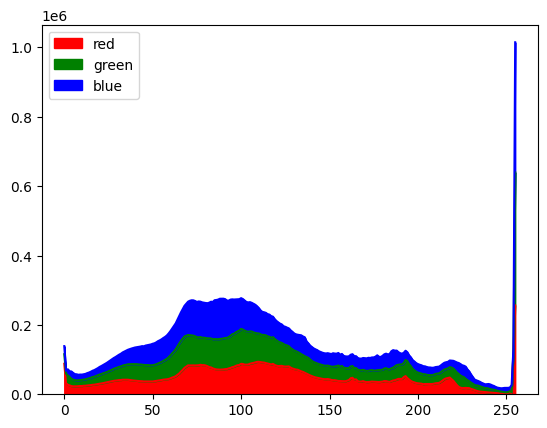

In [22]:
# Plot the histogram as a bar chart
df.plot.area(color=df.columns)

## Color frequency
But what if you wanted to look at the actual colors, not just their R, G, and B channels? You can do that too!

This is a bit more complex. In the `RGB` mode, there are 256^3 = 16,777,216 possible colors. An image of 2000 px x 1500 px will only have 3,000,000 pixels. Trying to count the the number of pixels with a specific color might get you a very small count for any given color — and lots of zeros.

Instead, we'll want to do some compression that groups colors into a smaller, limited set of colors.

`PIL` has a dedicated `P` mode — for palette — that does exactly that! It reduces your image to 256 unique colors, which are stored as a palette. Then, each pixel gets a single byte (eight bits) that indicates which color in the palette it belongs to.

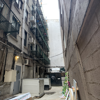

In [25]:
# Use our smaller image
smaller_img

In [24]:
# Let's convert our RGB image to the P mode
p_img = smaller_img.convert("P")

We can use the `Image.getcolors()` method, which returns a list of pairs of values. Each pair is the count and color in the palette (0 to 255). So it looks something like:

```
[
    (10, 1), # ten pixels have the 2nd color in the palette
    (100, 0), # one hundred pixels have the 1st color iin the palette
    ...
]
```

In [26]:
# Get the number of pixels for each color in the palette
color_counts = p_img.getcolors()
color_counts

[(85, 0),
 (22, 11),
 (38, 16),
 (40, 17),
 (61, 46),
 (42, 47),
 (120, 52),
 (1475, 53),
 (305, 54),
 (143, 59),
 (505, 60),
 (19, 61),
 (3, 66),
 (2, 67),
 (1, 88),
 (273, 89),
 (190, 90),
 (3, 91),
 (208, 95),
 (2379, 96),
 (426, 97),
 (149, 102),
 (245, 103),
 (9, 104),
 (1, 108),
 (2, 109),
 (1, 110),
 (2, 111),
 (1, 125),
 (162, 132),
 (94, 133),
 (127, 138),
 (1014, 139),
 (93, 140),
 (1, 144),
 (80, 145),
 (164, 146),
 (3, 147),
 (97, 175),
 (50, 176),
 (80, 181),
 (647, 182),
 (44, 183),
 (45, 188),
 (22, 189),
 (84, 218),
 (19, 219),
 (73, 224),
 (351, 225)]

Next, we make a new `pandas` DataFrame from this data. This time, we start with two columns: `count` for the number of pixels and `color_index` for the color value in the palette.

In [27]:
# Make a pandas DataFrame (2D table)
df = pd.DataFrame(color_counts, columns=["count", "color_index"])

# Here are a few more DataFrame methods to check out work so far
print(f"The smallest color index is {df['color_index'].min()}")
print(f"The largest color index is {df['color_index'].max()}")
print(
    f"There are {df['count'].sum()} total pixels in the table. The image is {p_img.size} in size."
)
df

The smallest color index is 0
The largest color index is 225
There are 10000 total pixels in the table. The image is (100, 100) in size.


,count,color_index
0,85,0
1,22,11
2,38,16
3,40,17
4,61,46
5,42,47
6,120,52
7,1475,53
8,305,54
9,143,59


In order to plot this chart with colors, we need to create a _third_ column `color` with the actual R, G, B values. We can do this with a `DataFrame.apply()` function. For this notebook, you just need to run the cell. Later in the course we'll learn to leverage `apply()` functions to perform operations on your data!

In [28]:
# Get the palette
p = p_img.getpalette()

# Create a color column based on the color_index column and the color palette
# We divide by 255 as we need R, G, B values in their decimal representation for plotting
df["color"] = df["color_index"].apply(
    lambda x: [v / 255.0 for v in p[x * 3 : x * 3 + 3]]
)
df

,count,color_index,color
0,85,0,"[0.0, 0.0, 0.0]"
1,22,11,"[0.2, 0.0, 0.0]"
2,38,16,"[0.0, 0.2, 0.0]"
3,40,17,"[0.2, 0.2, 0.0]"
4,61,46,"[0.0, 0.0, 0.2]"
5,42,47,"[0.2, 0.0, 0.2]"
6,120,52,"[0.0, 0.2, 0.2]"
7,1475,53,"[0.2, 0.2, 0.2]"
8,305,54,"[0.4, 0.2, 0.2]"
9,143,59,"[0.2, 0.4, 0.2]"


<Axes: >

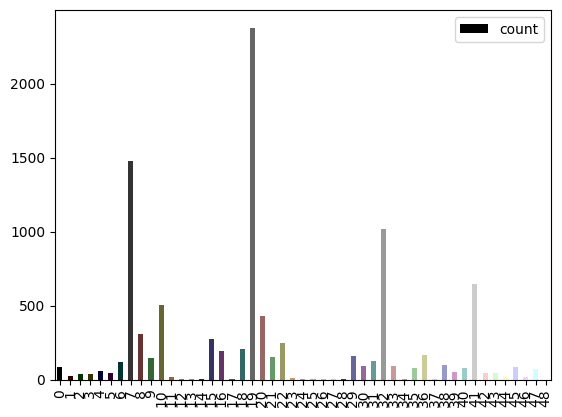

In [29]:
# Plot your colors
df.plot.bar(y="count", color=df["color"])

The above chart has each color in the palette on the X-axis, and the number of pixels with that color on the Y-axis. Note that the colors are sorted in a way that goes from black (0, 0, 0) to white (255, 255, 255). But because you are sorting values with three independent dimensions — red, green, and blue — there is not a definitive way to order them.

`PIL` makes an assumption about how best to sort the colors. But there are lots of alternatives ( [this](https://www.alanzucconi.com/2015/09/30/colour-sorting/) is a pretty good write-up). In general, this is a good example of how organizing and summarizing information is a choice with tradeoffs.

You'll need to navigate and negotiate similar choices in your own work over the semester.

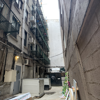

In [30]:
# Does it look right?
smaller_img

And of course, you should always check your work to see if it makes sense! As a very approximate "test" — does the color frequency displayed above match what you'd expect from the image thumbnail?

## Accessing pixels
Of course, images are just pixels! And `PIL` gives you a way to look just at those.

If you access pixels directly on a high-res image, you'll notice there are a lot of them (e.g. all those megapixels you hear about on cameras — a 8064 x 6048 image is almost 50 _million_ pixels).

The power of `PIL`'s summary functions is that they handle all that pixel data for you. If you do want to access them directly, you should reduce the size of your image with `Image.resize()` or `Image.thumbnail()`.  

The thumbnailed image is (75, 100)


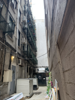

In [31]:
# Let's use the image we thumbnailed before.
print(f"The thumbnailed image is {new_img.size}")
new_img

`PIL` gives you ways to look at exactly one pixel, using its X and Y position. In `PIL`, pixels are ordered from top-left, with positive X being to the right and positive Y being down.

In [32]:
# Try getting a single pixel value
print(f"The RGB color value with the pixel at (0, 0) is {new_img.getpixel((0, 0))}")

The RGB color value with the pixel at (0, 0) is (61, 66, 76)


Of course, you can also get _all_ the pixels! Again, as a note of warning this can create a large data object so use with caution.

`Image.getadata()` returns a custom `PIL` sequence, which can be converted to a more typical Python `list`. The pixels are ordered line-by-line, going left-to-right and top-to-bottom. 

In [33]:
# For simplicity, we'll convert this image from RGB to P mode
p_img = new_img.convert("P")

# Get all the pixels. This is done line-by-line.
pixels = list(p_img.getdata())

To help organize the pixels, we can create a list of lists. That is, if the image is organized as follow:

```
       col 1  col 2  col 3
row 1    1      2      4
row 2    0      0      1
...
```

We can create a list of lists that looks like:

```
[
  [1, 2, 4],
  [0, 0, 1],
  ...
]
```

This will require a loop to build up the list.

In [34]:
# We need the width of the image to help sort the data
width = p_img.width

# We'll create an empty list to hold the data
# What we want is a list of sublists. Each sublist should be a row of pixel colors.
pixel_data = []

# We'll create a loop that iterates as many times as there are rows
# The range() function loops from 0 to the provided number
# In this case, that's the number of pixels divided by the width
for row in range(len(pixels) // width):
    # Let's create our sublist, which goes from the
    # first to last pixel in the row
    row_data = pixels[row * width : (row + 1) * width]

    # We'll use the append() function to add our sublist
    pixel_data.append(row_data)

Now that we have the list of lists, we can more easily work with them. For example, as a table!

In [35]:
pd.DataFrame(pixel_data)

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,53,53,53,95,54,95,53,53,53,95,...,139,96,89,96,96,53,90,53,53,89
1,96,89,53,89,96,54,95,89,53,89,...,139,96,53,96,96,53,95,54,95,53
2,95,90,59,53,89,96,53,53,89,96,...,138,96,89,96,54,89,60,89,54,53
3,96,95,89,53,53,96,89,53,89,102,...,139,90,96,96,53,96,53,53,95,54
4,96,96,96,53,89,59,96,53,89,139,...,138,89,60,96,53,90,59,90,53,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,53,53,53,60,90,96,96,60,96,60,...,102,96,96,96,96,97,102,96,96,60
96,53,60,90,59,96,60,96,96,96,96,...,97,96,97,96,60,96,97,97,96,97
97,96,60,96,54,96,96,97,96,97,96,...,103,96,60,97,97,96,96,96,97,96
98,53,90,59,90,96,102,139,96,132,181,...,96,97,96,96,96,103,96,60,96,96


### Puzzles
- TBD